# Calibration de la volatilité locale par thin plate spline interpolation

In [1]:
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
import json
import pandas as pd
import os
import matplotlib
from scipy.signal import convolve

# import de données (volatilité locale pour différents strikes et différentes maturités)

In [2]:
def parse_multiple_lines(filename):
    list_arrays = []
    with open(filename, 'r') as f:
        for i, line in enumerate(f):
            line = line.rstrip()
            array = parse_volsurface_string(line)
            list_arrays.append(array)
    return np.concatenate(list_arrays)

def parse_volsurface_folder(folder):
    list_arrays = []
    for filename in os.listdir(folder):
        folder_path = os.path.join(folder,filename)
        array = parse_volsurface_file(folder_path)
        list_arrays.append(array)
    return np.concatenate(list_arrays)


def parse_volsurface_file(file):
    with open(file, 'r') as file:
        data = file.read()
    return parse_volsurface_string(data)

def parse_volsurface_string(data):
    json_string = ",".join(data.split(',')[4:]).replace('""','"')[1:-1]
    json_data = json.loads(json_string)
    volsurface_dict =json_data["surface"]
    length = len(volsurface_dict)
    array = np.zeros((length,3,3))
    for i,key in enumerate(volsurface_dict):
        array[i,0,0]=parse_tenor_string(volsurface_dict[key]["tenor"])
        array[i,0,1]=volsurface_dict[key]["smile"]["25"]
        array[i,0,2]=volsurface_dict[key]["vol_spread"]["25"]

        array[i,1,0]=parse_tenor_string(volsurface_dict[key]["tenor"])
        array[i,1,1]=volsurface_dict[key]["smile"]["50"]
        array[i,1,2]=volsurface_dict[key]["vol_spread"]["50"]

        array[i,2,0]=parse_tenor_string(volsurface_dict[key]["tenor"])
        array[i,2,1]=volsurface_dict[key]["smile"]["75"]
        array[i,2,2]=volsurface_dict[key]["vol_spread"]["75"]
    return array



def parse_tenor_string(tenor_string):
    if tenor_string.endswith("W"):
        return 7*float(tenor_string[:-1])
    elif tenor_string.endswith("M"):
        return 30*float(tenor_string[:-1])
    elif tenor_string.endswith("Y"):
        return 365*float(tenor_string[:-1])
    elif tenor_string =="ON":
        return 1.0
    else : raise("unknown tenor format")

In [3]:
volatility_surface_parsed = parse_volsurface_folder("volsurface_data/")

In [4]:
volatility_surface_25_50_75 = volatility_surface_parsed[:11] # éviter des doublons

Tracé des données

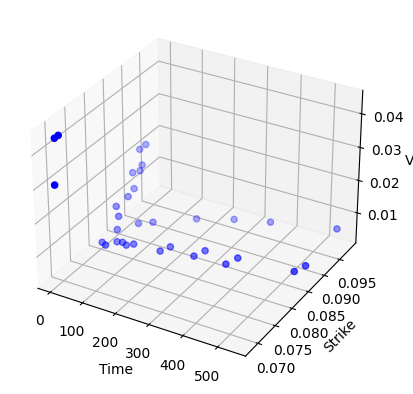

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(volatility_surface_25_50_75[:,0,0],volatility_surface_25_50_75[:,0,1] ,volatility_surface_25_50_75[:,0,2] , c='b')
ax.scatter(volatility_surface_25_50_75[:,1,0],volatility_surface_25_50_75[:,1,1] ,volatility_surface_25_50_75[:,1,2] , c='b')
ax.scatter(volatility_surface_25_50_75[:,2,0],volatility_surface_25_50_75[:,2,1] ,volatility_surface_25_50_75[:,2,2] , c='b')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()


# Simulation d'une surface de vol impli
Je prends une fonction quadratique en strike et exponentielle en temps

In [6]:
def simulated_implied_volatility(T,K) : 
    return np.exp(-0.5*T)*(4*10**(-6)*K*K -8*10**(-4)*K+0.05) + 0.2

def simulated_implied_volatility_2(T,K):
    return -0.005*T -K/200 + 0.5

creation de la vol impli + ajout d'un peu de bruit

In [7]:
strikes = np.linspace(0,120,100)
times = np.linspace(0,3,100)
T, K = np.meshgrid(times,strikes)

kernel = 1/100*np.ones((10,10))
impvol = convolve(np.clip(simulated_implied_volatility_2(T,K),0.1,None),kernel,mode='valid')


tracé

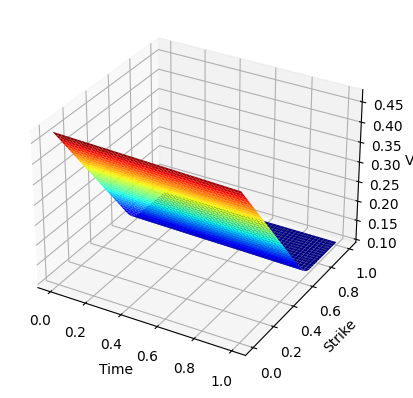

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
n,p = np.shape(impvol)
a,b = np.meshgrid(np.linspace(0,1,n),np.linspace(0,1,p))
ax.plot_surface(a,b, impvol, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

# Traitement des données (tri en S croissant,normalisation,...)

In [9]:
volatility_surface = np.concatenate([volatility_surface_25_50_75[:,0,:],volatility_surface_25_50_75[:,1,:],volatility_surface_25_50_75[:,2,:]])

In [10]:
tableau =volatility_surface_25_50_75[:,1,:]
indices_tri = np.argsort(tableau[:,0])
volatility_surface_atm_tri = tableau[indices_tri]


In [11]:
volatility_surface_otm_tri = volatility_surface_25_50_75[:,0,:][indices_tri]
volatility_surface_itm_tri = volatility_surface_25_50_75[:,2,:][indices_tri]

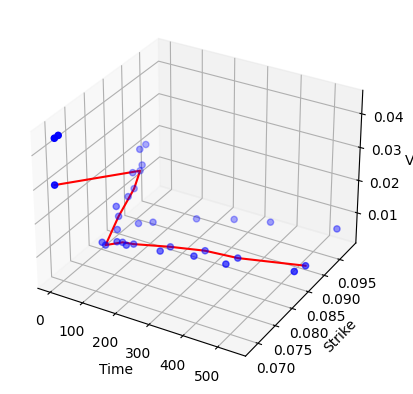

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(volatility_surface[:,0],volatility_surface[:,1] ,volatility_surface[:,2] , c='b')
ax.plot(volatility_surface_atm_tri[:,0],volatility_surface_atm_tri[:,1],volatility_surface_atm_tri[:,2],c='red')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()


In [13]:
spot_initial = volatility_surface_atm_tri[0,1]
print(spot_initial)

0.068625


In [14]:
np.shape(volatility_surface)

(33, 3)

In [15]:
min_vals = np.min(volatility_surface, axis=0) 
max_vals = np.max(volatility_surface, axis=0) 
normalized_data = (volatility_surface - min_vals) / (max_vals - min_vals)

In [16]:
scale = max_vals-min_vals
offset = min_vals

In [17]:
X,Y,Z = normalized_data[:,0],normalized_data[:,1],normalized_data[:,2]

# Thin plate spline interpolation

interpolation (smooth correspond au paramètre d'e lissage $\alpha$)

In [18]:
rbf = Rbf(X, Y, Z, function='thin_plate',smooth = 0.)

extrapolation

In [19]:
x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0.0, 1, 100))
z_interp = rbf(x, y)


tracé

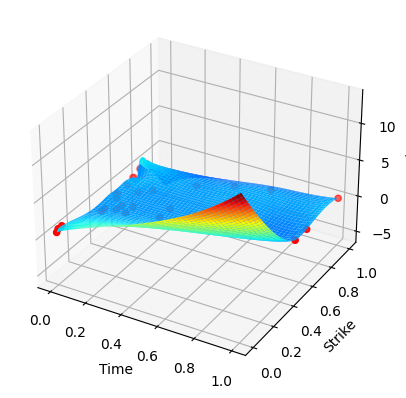

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z_interp, cmap='jet')
ax.scatter3D(X,Y,Z, c = 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

remise à l'échelle

In [21]:
x_rescaled, y_rescaled = np.meshgrid(np.linspace(0, 1, 100)*scale[0]+offset[0], np.linspace(0.0, 1, 100)*scale[1]+offset[1])
z_rescaled = z_interp*scale[2]+offset[2]

tracé de la surface de vol impli interpolée par TPS (remise à l'échelle), et l'évolution du spot dans le temps (courbe en rouge).

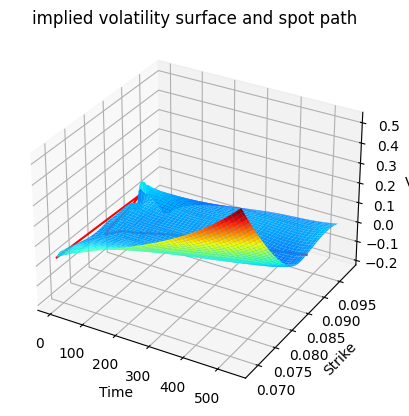

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_rescaled, y_rescaled, z_rescaled, cmap='jet')
normalized_atm_x, normalized_atm_y = (volatility_surface_atm_tri[:,0]-offset[0])/scale[0],(volatility_surface_atm_tri[:,1]-offset[1])/scale[1]
normalized_atm_z = np.array([rbf(normalized_atm_x[i],normalized_atm_y[i])for i in range(len(normalized_atm_x))])
rescaled_atm_z = normalized_atm_z*scale[2]+offset[2]
ax.plot(volatility_surface_atm_tri[:,0],volatility_surface_atm_tri[:,1],rescaled_atm_z,c='red')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
ax.set_title('implied volatility surface and spot path')
plt.show()

tracé selon T = cste

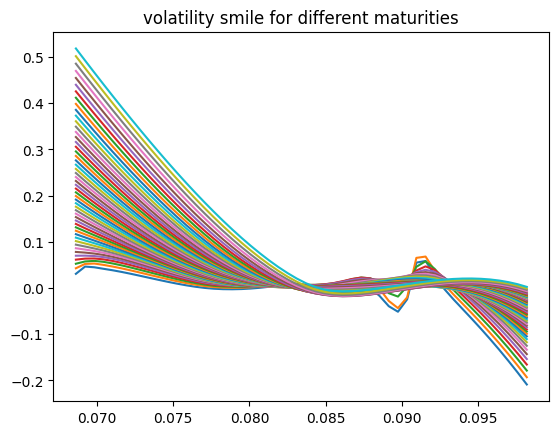

In [23]:
N = 50
for i in range(N):
    maturities,spots = np.meshgrid(np.array([i/N]),np.linspace(0,1))
    impvol_among_constant_T = rbf(maturities,spots)*scale[2]+offset[2]
    plt.plot(spots*scale[1]+offset[1],impvol_among_constant_T)
plt.title('volatility smile for different maturities')
plt.show()

Calcul du "Butterfly" pour les différentes cotations. (test de la convexité de la vol impli en le spot, au voisinage de la zone "at the money" )

normalizing the sorted version of in the money and out of the money call prices

In [24]:
normalized_otm_x, normalized_otm_y = (volatility_surface_otm_tri[:,0]-offset[0])/scale[0],(volatility_surface_otm_tri[:,1]-offset[1])/scale[1]
normalized_itm_x, normalized_itm_y = (volatility_surface_itm_tri[:,0]-offset[0])/scale[0],(volatility_surface_itm_tri[:,1]-offset[1])/scale[1]

taking the images through interpolation 

In [25]:
normalized_otm_z = np.array([rbf(normalized_otm_x[i],normalized_otm_y[i])for i in range(len(normalized_otm_x))])
normalized_itm_z = np.array([rbf(normalized_itm_x[i],normalized_itm_y[i])for i in range(len(normalized_itm_x))])


computing the (adimensioned) butterfly

In [26]:
butterfly_adim = 0.5*(normalized_otm_z+normalized_itm_z)-normalized_atm_z

rescaling

In [27]:
butterlfy = butterfly_adim*scale[2] # no need to add offset since it cancells out

Text(0.5, 1.0, 'butterfly')

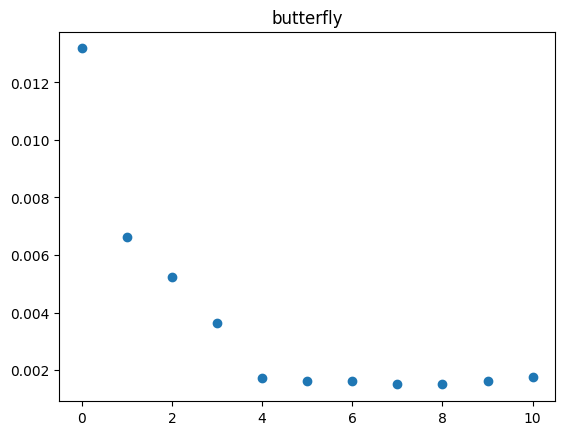

In [28]:
absc = np.arange(0,np.shape(butterlfy)[0],1)
plt.scatter(absc,butterlfy)
plt.title('butterfly')

Butterfly positif --> ça a l'air correct

# Data augmentation
Pour éviter les problèmes numérique avec la formule liant volatilité implicite et volatilité locale, il existe une technique consistant à ajouter aux données des valeurs constantes de volatilité pour des spots au dessus (resp en dessous) de 1.25 ATM (resp 0.75 ATM). En prenant comme valeur de référence la valeur de la volatilité à 1.25 ATM (resp 0.75 ATM)

In [29]:
sorted_indices = np.lexsort((volatility_surface[:, 1], volatility_surface[:, 0]))
sorted_vol_surface = volatility_surface[sorted_indices]
cleaned_vol_surface = sorted_vol_surface[3:]


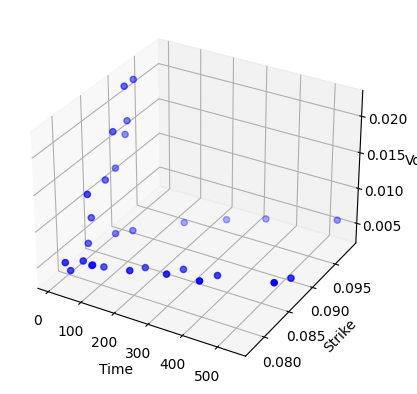

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cleaned_vol_surface[:,0],cleaned_vol_surface[:,1] ,cleaned_vol_surface[:,2] , c='b')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()


In [ ]:
def data_augmentation(volatility_surface):
    n,p = np.shape(volatility_surface)
    nb_maturities = n//3
    augmented_surface = np.zeros((nb_maturities*7,3))
    for i in range(nb_maturities):
        augmented_surface[7*i] = volatility_surface[3*i]
        augmented_surface[7*i+1] = volatility_surface[3*i+1]
        augmented_surface[7*i+2] = volatility_surface[3*i+2]
        for j in range(2):
            augmented_surface[7*i+3+j,0] = volatility_surface[3*i,0]
            nb = (0.6+0.1*j)
            augmented_surface[7*i+3+j,1] = nb*volatility_surface[3*i,1]
            augmented_surface[7*i+3+j,2]= volatility_surface[3*i,2]
        for j in range(2):
            augmented_surface[7*i+5+j,0] = volatility_surface[3*i+2,0]
            nb = (1.2 +0.1*j)
            augmented_surface[7*i+5+j,1] = nb*volatility_surface[3*i+2,1]
            augmented_surface[7*i+5+j,2] = volatility_surface[3*i+2,2]
    return(augmented_surface)


In [ ]:
augmented_surface = data_augmentation(cleaned_vol_surface[12:])
augmented_surface = cleaned_vol_surface[12:]

In [ ]:
spot_initial = augmented_surface[1,1]

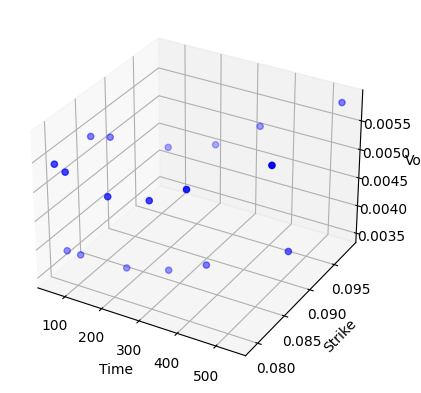

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(augmented_surface[:,0],augmented_surface[:,1] ,augmented_surface[:,2] , c='b')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

normalisation

In [ ]:
min_vals = np.min(augmented_surface, axis=0) 
max_vals = np.max(augmented_surface, axis=0) 
normalized_data = (augmented_surface - min_vals) / (max_vals - min_vals)

In [ ]:
scale = max_vals-min_vals
offset = min_vals

interpolation

In [ ]:
X,Y,Z = normalized_data[:,0],normalized_data[:,1],normalized_data[:,2]


In [ ]:
rbf = Rbf(X, Y, Z, function='thin_plate',smooth = 0.000)

extrapolation

In [ ]:
x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0.0, 1, 100))
z_interp = rbf(x, y)
z_clipped = np.clip(z_interp,0.02,1)

renormalization

In [ ]:
z_renormalized = z_interp*(max_vals[2] - min_vals[2])+min_vals[2]

tracé

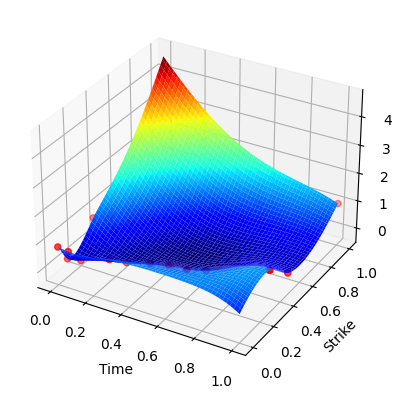

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z_interp, cmap='jet')
ax.scatter3D(X,Y,Z, c = 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

# 1er essai pour la formule du lien vol impli - vol locale

constructing the impvol surface (on a grid)

In [ ]:
x2 = np.linspace(0, 1, 1000)
y2 = np.linspace(0, 1, 1000)
xx, yy = np.meshgrid(x2, y2)
zz = rbf(xx,yy)

rescaling

In [ ]:
zz_rescaled = zz*scale[2]+offset[2] #no need for offset since we are going to differentiate

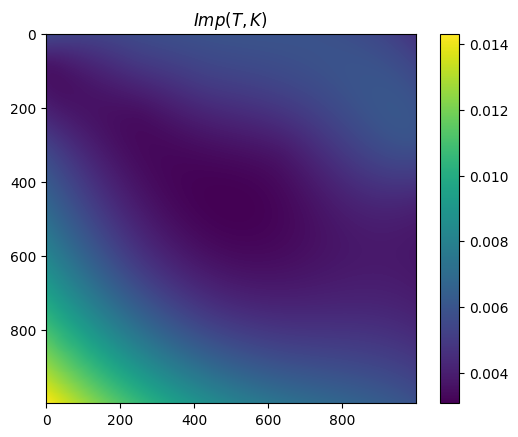

In [ ]:
plt.imshow(zz_rescaled)
plt.title("$Imp(T,K)$")
plt.colorbar()

dérivées partielles

In [ ]:
d_spline_d_maturity, d_spline_d_spot = np.gradient(zz_rescaled)

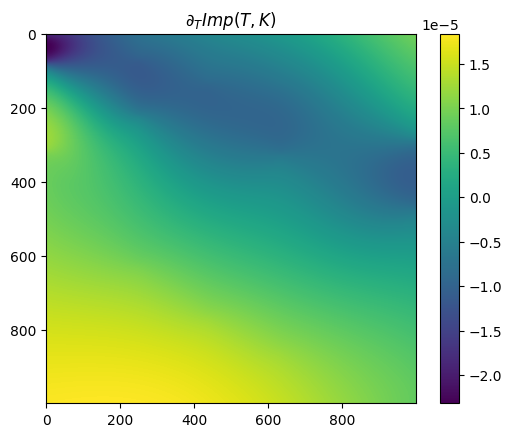

In [ ]:
plt.imshow(d_spline_d_maturity)
plt.title("$\partial_T Imp(T,K)$")
plt.colorbar()

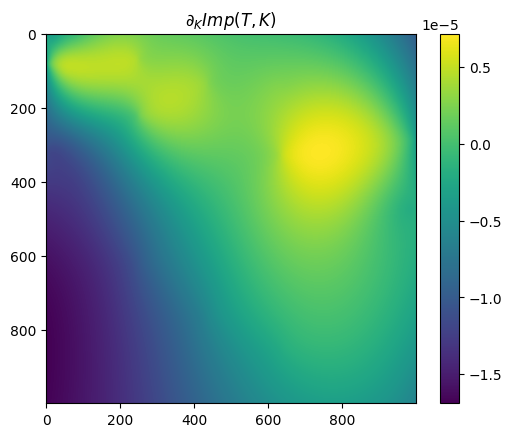

In [ ]:
plt.imshow(d_spline_d_spot)
plt.title("$\partial_K Imp(T,K)$")
plt.colorbar()

In [ ]:
d_spline_d_spot2,d_spline_d_maturity_spot = np.gradient(d_spline_d_spot)

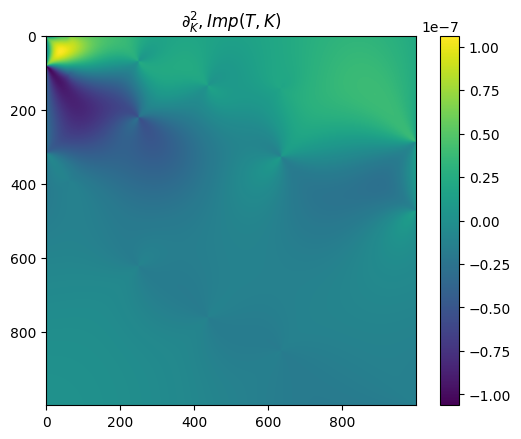

In [ ]:
plt.imshow(d_spline_d_spot2)
plt.title("$\partial^2_K, Imp(T,K)$")
plt.colorbar()

now --> pluging this into the dupire formula to get the local volatility

functions for that

In [ ]:
def d_plus(s,k,v):
    return np.log(s/k)/np.sqrt(v) + np.sqrt(v)/2

def d_moins(s,k,v):
    return np.log(s/k)/np.sqrt(v) - np.sqrt(v)/2

def disounted(K,r,T):
    return K*np.exp(-r*T)

def local_vol(T,K,S0,Impvol,partial_T,partial_K,partial2_K,r):
    return np.sqrt(local_vol_squared(T,K,S0,Impvol,partial_T,partial_K,partial2_K,r))

def local_vol_squared(T,K,S0,Impvol,partial_T,partial_K,partial2_K,r):
    num = numerateur(T,K,Impvol,partial_T,partial_K,r)
    den = denominateur(T,K,S0,Impvol,partial_T,partial_K,partial2_K,r)
    return num/den

def numerateur(T,K,Impvol,partial_T,partial_K,r):
    return Impvol/T +2*partial_T + 2*r*K*partial_K

def denominateur(T,K,S0,Impvol,partial_T,partial_K,partial2_K,r):
    term_1 = terme_1(K,T,Impvol)
    term_2 = terme_2(K,T,S0,Impvol,partial_K,r)
    term_3 = terme_3(K,T,S0,Impvol,partial_K,r)
    term_4 = partial2_K
    return K*K*(term_1+term_2+term_3+term_4)

def terme_1(K,T,Impvol):
    return 1/(K*K+Impvol*T)

def terme_2(K,T,S0,Impvol,partial_K,r):
    return 2*d_plus(S0,disounted(K,r,T),Impvol*Impvol*T)*partial_K/(K*Impvol*np.sqrt(T))

def terme_3(K,T,S0,Impvol,partial_K,r):
    return d_plus(S0,disounted(K,r,T),Impvol*Impvol*T)*d_moins(S0,disounted(K,r,T),Impvol*Impvol*T)*partial_K*partial_K/Impvol


In [ ]:
def build_local_volatility_surface(r,S0, min_vals,max_vals,N):
    local_volatility = np.zeros((N,N))

    scale = max_vals-min_vals
    offset = min_vals
    x,y = np.meshgrid(np.linspace(0,1,N),np.linspace(0,1,N))
    normalized_impvol = rbf(x,y)
    impvol = normalized_impvol*scale[2]+offset[2]
    # x,y = np.meshgrid(np.linspace(0,3,N),np.linspace(0,130,N))
    # impvol = simulated_implied_volatility(x,y)
    partial_T, partial_K = np.gradient(impvol)
    partial_K_T, partial_K2 = np.gradient(d_spline_d_spot)

    for indice_T in range(N):
        for indice_K in range(N):
            T = scale[0]*indice_T/N +offset[0]
            K = scale[1]*indice_K/N +offset[1]
            evaluation_impvol = impvol[indice_T,indice_K]
            evaluation_partial_T = partial_T[indice_T,indice_K]
            eveluation_partial_K = partial_K[indice_T,indice_K]
            evaluation_partial_K2 = partial_K2[indice_T,indice_K]

            
    
            local_volatility[indice_T,indice_K] = local_vol_squared(T,K,S0,evaluation_impvol,evaluation_partial_T,eveluation_partial_K,evaluation_partial_K2,r)
    return(local_volatility)

In [ ]:
local_volatility = build_local_volatility_surface(0.01,spot_initial,min_vals,max_vals,1000)

il y a des singularités --> je "clipe" les valeurs pour visualiser

In [ ]:
clipped_local_vol = np.clip(local_volatility,0,50)

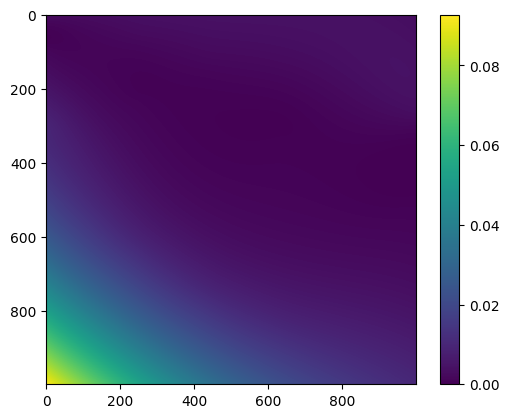

In [ ]:
plt.imshow(clipped_local_vol)
plt.colorbar()

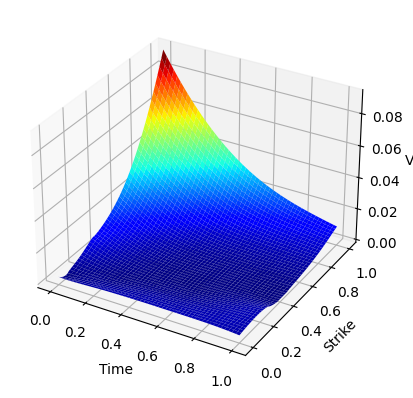

In [ ]:
x, y = np.meshgrid(np.linspace(0, 1, 1000), np.linspace(0.0, 1, 1000))
z_interp = rbf(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, clipped_local_vol, cmap='jet')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

In [ ]:
clipped_local_vol[100,100]

0.0011195863634058214

# 2è essai pour la formule --> en utilisant de la poo

In [ ]:
class local_vol_as_function_of_implied_vol:

    def __init__(self,impvol,range_T, range_K,r,S0) -> None:
        self.impvol = impvol
        n,p = np.shape(self.impvol)
        self.N_T = n 
        self.N_K = p 
        self.range_T = range_T
        self.range_K = range_K
        self.interest_rate =r
        self.initial_spot = S0
        self.array_T = np.tile(np.linspace(self.range_T[0],self.range_T[1],self.N_T), (self.N_K, 1))
        self.array_K = np.tile(np.linspace(self.range_K[0],self.range_K[1],self.N_K), (self.N_T, 1)).T
        partial_T, partial_K = np.gradient(self.impvol)
        partial_T_K,partial_K2 = np.gradient(partial_K)
        
        self.partial_T = partial_T
        self.partial_K = partial_K
        self.partial_K2 = partial_K2
        self.discounted = self.array_K*np.exp(-self.interest_rate*self.array_T)

        
    def d_plus(self):
        K_discounted = self.discounted
        return np.log(self.initial_spot/K_discounted)/self.impvol/np.sqrt(self.array_T) + 0.5*self.impvol*np.sqrt(self.array_T)
    
    def d_moins(self):
        K_discounted = self.discounted
        return np.log(self.initial_spot/K_discounted)/self.impvol/np.sqrt(self.array_T) - 0.5*self.impvol*np.sqrt(self.array_T)

    def numerator(self):
        return self.impvol/self.array_T +2*self.partial_T +2*self.interest_rate*self.array_K*self.partial_K
    
    def denominator(self):
        return self.array_K*self.array_K*(self.terme_1() + self.terme_2() +self.terme_3() +self.terme_4())

    def terme_1(self):
        t1 = 1/self.array_K/self.array_K/self.array_T/self.impvol
        print("norme terme1 : "+ str(np.linalg.norm(t1)))
        return t1
    
    def terme_2(self):
        t2 = 2*self.d_plus()*self.partial_K/self.array_K/self.impvol/np.sqrt(self.array_T)
        print("norme terme2 : "+ str(np.linalg.norm(t2)))
        return t2
    
    def terme_3(self):
        t3 = self.d_plus()*self.d_moins()*self.partial_K**2/self.impvol
        print("norme terme3 : "+ str(np.linalg.norm(t3)))
        return t3
    
    def terme_4(self):
        t4 = self.partial_K2
        print("norme terme4 : "+ str(np.linalg.norm(t4)))
        return t4
    
    def local_volatility_squared(self):
        return np.clip(self.numerator()/self.denominator(), 0,None)

    def local_volatility(self):
        return np.sqrt(self.local_volatility_squared())
    
    def naive_local_volatility_squared(self):
        return np.clip(self.impvol*self.impvol + 2*self.impvol*self.partial_K*self.array_T,0,None)
    
    def naive_local_volatility(self):
        return np.sqrt(self.naive_local_volatility_squared())
        

problème dans la formule --> je repars de 0

In [ ]:
class local_vol_as_function_of_implied_vol:

    def __init__(self,impvol,range_T, range_K,r,S0) -> None:
        self.impvol = impvol #np.clip(impvol,0.01,None)
        n,p = np.shape(self.impvol)
        self.N_T = n 
        self.N_K = p 
        self.range_T = range_T
        self.range_K = range_K
        self.scale_T =self.range_T[-1]-self.range_T[0]
        self.scale_K = self.range_K[-1]-self.range_K[0]
        self.dT = self.scale_T/self.N_T
        self.dK = self.scale_K/self.N_K


        self.interest_rate =r
        self.initial_spot = S0
        self.array_T = np.tile(np.linspace(self.range_T[0],self.range_T[1],self.N_T), (self.N_K, 1))
        self.array_K = np.tile(np.linspace(self.range_K[0],self.range_K[1],self.N_K), (self.N_T, 1)).T
        

        partial_K, partial_T = np.gradient(self.impvol,self.dK,self.dT)
        partial_K2,partial_K_T = np.gradient(partial_K,self.dK,self.dT)

        self.partial_T = partial_T
        self.partial_K = partial_K
        self.partial_K2 = partial_K2
        self.discounted = self.array_K*np.exp(-self.interest_rate*self.array_T)

    def log(self):
        return np.log(self.initial_spot/self.discounted)
    
    def terme_log(self):
        return self.log()/self.impvol/np.sqrt(self.array_T)
   
    def terme_racine(self):
        return 0.5*self.impvol*np.sqrt(self.array_T)
    
    def d_plus(self):
        return  self.terme_log()+self.terme_racine() 
    
    def d_moins(self):
        return self.terme_log()-self.terme_racine() 

    def numerator(self):
        return self.impvol/self.array_T +2*self.partial_T +2*self.interest_rate*self.array_K*self.partial_K
    
    def denominator(self):
        return self.array_K*self.array_K*(self.terme_1() + self.terme_2() +self.terme_3() +self.terme_4())

    def terme_1(self):
        t1 = 1/self.array_K/self.array_K/self.array_T/self.impvol
        print("norme terme1 : "+ str(np.linalg.norm(t1)))
        return t1
    
    def terme_2(self):
        t2 = 2*self.d_plus()*self.partial_K/self.array_K/self.impvol/np.sqrt(self.array_T)
        print("norme terme2 : "+ str(np.linalg.norm(t2)))
        return t2
    
    def terme_3(self):
        t3 = self.d_plus()*self.d_moins()*self.partial_K**2/self.impvol
        print("norme terme3 : "+ str(np.linalg.norm(t3)))
        return t3
    
    def terme_4(self):
        t4 = self.partial_K2
        print("norme terme4 : "+ str(np.linalg.norm(t4)))
        return t4
    
    def local_volatility_squared(self):
        return np.clip(self.numerator()/self.denominator(), 0,None)

    def local_volatility(self):
        return np.sqrt(self.local_volatility_squared())
    
    def naive_local_volatility_squared(self):
        return np.clip(self.impvol*self.impvol + 2*self.impvol*self.partial_T*self.array_T,0,None)
    
    def naive_local_volatility(self):
        return np.sqrt(self.naive_local_volatility_squared())
        

# Toujours des problèmes, 3è essai avec une autre écriture de la formule

In [ ]:
class local_vol_as_function_of_implied_vol:

    def __init__(self,impvol,range_T, range_K,r,S0) -> None:
        self.impvol = impvol
        n,p = np.shape(self.impvol)
        self.N_T = n 
        self.N_K = p 
        self.range_T = range_T
        self.range_K = range_K
        self.scale_T =self.range_T[-1]-self.range_T[0]
        self.scale_K = self.range_K[-1]-self.range_K[0]
        self.dT = self.scale_T/self.N_T
        self.dK = self.scale_K/self.N_K
        self.interest_rate =r
        self.initial_spot = S0
        self.array_T = np.tile(np.linspace(self.range_T[0],self.range_T[1],self.N_T), (self.N_K, 1))
        self.array_K = np.tile(np.linspace(self.range_K[0],self.range_K[1],self.N_K), (self.N_T, 1)).T

        partial_K, partial_T = np.gradient(self.impvol,self.dK,self.dT)
        partial_K2,partial_K_T = np.gradient(partial_K,self.dK,self.dT)

        self.partial_T = partial_T
        self.partial_K = partial_K
        self.partial_K2 = partial_K2
        self.discounted = self.array_K*np.exp(-self.interest_rate*self.array_T)
        self.y = np.log(self.array_K/self.initial_spot)-self.interest_rate*self.array_T

    def numerateur(self):
        return self.impvol**2+ 2*self.impvol*self.array_T*self.terme_numerateur()
    
    def terme_numerateur(self):
        return self.partial_T+self.interest_rate*self.array_K*self.partial_K
    
    def denominateur(self):
        return self.terme_denominateur_1() +self.array_K*self.impvol*self.array_T*self.terme_denominateur_2()

    def terme_denominateur_1(self):
        return (np.ones((self.N_T,self.N_K))-self.array_K*self.y*self.partial_K/self.impvol)**2
    
    def terme_denominateur_2(self):
        return self.partial_K-0.25*self.array_K*self.impvol*self.array_T*self.partial_K**2 +self.array_K*self.partial_K2

    def local_variance(self):
        return np.clip(self.numerateur()/self.denominateur(),0,None)
    
    def naive_local_variance(self):
        return np.clip(self.impvol**2 +2*self.impvol*self.array_T*self.partial_T,0,None)
    
    def local_volatility(self):
        return np.sqrt(self.local_variance())
    
    def naive_local_volatility(self):
        return np.sqrt(self.naive_local_variance())
        

 Les 2è et 3è approches donnent des resultats identiques --> c'est que la formules est correcte. Le soucis vient des données. 

In [ ]:
def visualize(array):
    n,p = np.shape(array)
    x, y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0.0, 1, p))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x, y, array, cmap='jet')
    ax.set_xlabel('Temsp (normalisé)')
    ax.set_ylabel('Spot (normalisé)')
    ax.set_zlabel('Vol')
    plt.show()

market data (n'exécuter que la cellule qui correspond aux données que l'on veut traiter)

In [ ]:
x,y = np.meshgrid(np.linspace(0,1,600),np.linspace(0,1,600))
normalized_impvol = rbf(x,y)
normalized_clipped_impvol = np.clip(normalized_impvol,0,1.5)
impvol = normalized_impvol*scale[2]+offset[2]  

simulated data

In [ ]:
strikes = np.linspace(0,120,600)
times = np.linspace(0,3,600)
T, K = np.meshgrid(times,strikes)
kernel = 1/10000*np.ones((100,100))
impvol = np.clip(simulated_implied_volatility_2(T,K),0.1,None)
impvol = convolve(impvol,kernel,mode = 'valid')


calibration par la formule lien vol locale-vol impli

In [ ]:
normalized_initial_spot = (spot_initial-min_vals[1])/(max_vals[1]-min_vals[1])


In [ ]:
range_T = np.array([0.1,1])
range_K = np.array([0.1,1])
dupire_formula = local_vol_as_function_of_implied_vol(impvol,range_T , range_K , 0.003, 0.5)

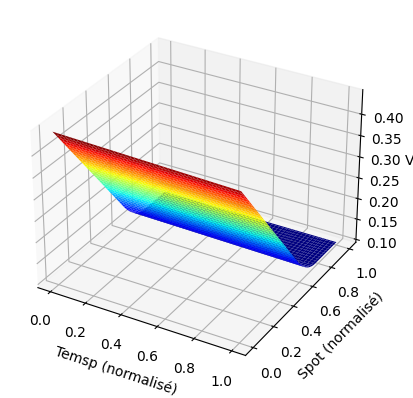

In [ ]:
visualize(dupire_formula.impvol)

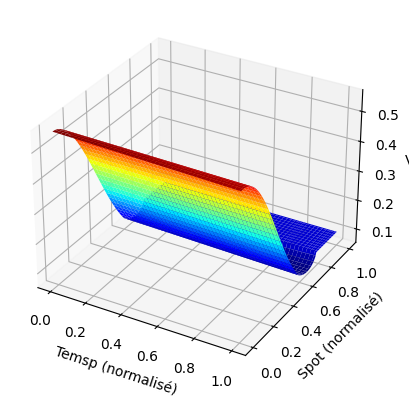

In [ ]:
visualize(np.clip(dupire_formula.local_volatility(),0.0,1))

enregistrer la surface de volatilité locale dans un fichier .npy

In [ ]:
local_vol = dupire_formula.local_volatility()
np.save('local_vol.npy',local_vol)

# pricing avec cette surface de volatilité

## 1ère approche : passer cette volatilité comme surface de vol implicite dans les paramètres du solveur
ça demande de convertir le np.array en un dictionnaire au bon format

In [ ]:
pip install ..

Processing /Users/leveilley/Documents/Code/regentmarket_quants/quants
  Preparing metadata (setup.py) ... done
  Created wheel for deriv-quant-package: filename=deriv_quant_package-0.1-py3-none-any.whl size=93091 sha256=620cb585ed38149bb546e8e4e1a84a6d726432874a7f869e0e850423fb34a942
  Stored in directory: /private/var/folders/lc/7jrt0k4d2yn7qgs_f7c_njgm0000gn/T/pip-ephem-wheel-cache-zlznpum_/wheels/23/5a/c7/65f863e892436700b3855e331c7147a6383614a1a494da4bbf
Successfully built deriv-quant-package
  Attempting uninstall: deriv-quant-package
    Found existing installation: deriv-quant-package 0.1
    Uninstalling deriv-quant-package-0.1:
      Successfully uninstalled deriv-quant-package-0.1
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pricer.pricing_engine.pricer import pde_pricer

lecture du tableau contenant la volatilité impli.

cellule pour transformer un tableau numpy en dictionaire au bon format pour la volatilité

In [ ]:
vol_dict = {}
for i in range(600):
    dict = {}
    for j in range(600):
        dict[min_vals[1]+(max_vals[1]-min_vals[1])*j/600] = local_vol[i,j]
    vol_dict[min_vals[0]+(max_vals[0]-min_vals[0])*i/600] = dict
    

IndexError: index 501 is out of bounds for axis 1 with size 501

transformer un tableau numpy conenant la surface de vol (2è méthode)

In [ ]:
augmented_surface

array([[6.00000000e+01, 7.92625100e-02, 5.42857143e-03],
       [6.00000000e+01, 8.07500100e-02, 3.80000000e-03],
       [6.00000000e+01, 8.52375100e-02, 5.42857143e-03],
       [9.00000000e+01, 7.91750000e-02, 5.35715714e-03],
       [9.00000000e+01, 8.11750000e-02, 3.75001000e-03],
       [9.00000000e+01, 8.66750000e-02, 5.35715714e-03],
       [1.80000000e+02, 8.05125000e-02, 5.00000000e-03],
       [1.80000000e+02, 8.34000000e-02, 3.50000000e-03],
       [1.80000000e+02, 9.10375000e-02, 5.00000000e-03],
       [2.70000000e+02, 8.17625000e-02, 5.00000000e-03],
       [2.70000000e+02, 8.50000000e-02, 3.50000000e-03],
       [2.70000000e+02, 9.36875000e-02, 5.00000000e-03],
       [3.65000000e+02, 8.19000000e-02, 5.35714286e-03],
       [3.65000000e+02, 8.54250000e-02, 3.75000000e-03],
       [3.65000000e+02, 9.54000000e-02, 5.35714286e-03],
       [5.40000000e+02, 8.46625000e-02, 5.85714286e-03],
       [5.40000000e+02, 8.82000000e-02, 4.10000000e-03],
       [5.40000000e+02, 9.81875

In [ ]:
vol_dict = {}
for tenor in set(augmented_surface[:,0]):
    dict = {}
    indexes = np.where(augmented_surface==tenor)
    for index in indexes[0]:
        dict[augmented_surface[index,1]] = augmented_surface[index,2]
    vol_dict[tenor] = dict
print(vol_dict)

{365.0: {0.0819: 0.00535714285714286, 0.085425: 0.00375, 0.0954: 0.00535714285714286}, 270.0: {0.0817625: 0.00500000000000002, 0.085: 0.00350000000000002, 0.0936875: 0.00500000000000002}, 180.0: {0.0805125: 0.00500000000000002, 0.0834: 0.00350000000000002, 0.0910375: 0.00500000000000002}, 90.0: {0.079175: 0.00535715714285714, 0.081175: 0.00375001, 0.086675: 0.00535715714285714}, 60.0: {0.07926251: 0.00542857142857143, 0.08075001: 0.0038, 0.08523751: 0.00542857142857143}, 540.0: {0.0846625: 0.00585714285714285, 0.0882: 0.00409999999999999, 0.0981875: 0.00585714285714285}}


In [ ]:
vol_dict

{365.0: {0.0819: 0.00535714285714286,
  0.085425: 0.00375,
  0.0954: 0.00535714285714286},
 270.0: {0.0817625: 0.00500000000000002,
  0.085: 0.00350000000000002,
  0.0936875: 0.00500000000000002},
 180.0: {0.0805125: 0.00500000000000002,
  0.0834: 0.00350000000000002,
  0.0910375: 0.00500000000000002},
 90.0: {0.079175: 0.00535715714285714,
  0.081175: 0.00375001,
  0.086675: 0.00535715714285714},
 60.0: {0.07926251: 0.00542857142857143,
  0.08075001: 0.0038,
  0.08523751: 0.00542857142857143},
 540.0: {0.0846625: 0.00585714285714285,
  0.0882: 0.00409999999999999,
  0.0981875: 0.00585714285714285}}

en attendant d'avoir des données qui tiennent la route --> teste sur mes données simulées

In [ ]:
simulated_surface = np.zeros((100,3))
n,p = np.shape(impvol)
for tenor_index in range(5):
    for spot_index in range(20):
        index=20*tenor_index+spot_index
        simulated_surface[index,0]=(tenor_index+1)*30
        simulated_surface[index,1]=spot_index/20 +0.5
        i,j = int(p*spot_index/20),int(n*tenor_index/5)
        simulated_surface[index,2]=impvol[i,j]
simulated_surface

array([[3.00000000e+01, 5.00000000e-01, 4.49177796e-01],
       [3.00000000e+01, 5.50000000e-01, 4.24136060e-01],
       [3.00000000e+01, 6.00000000e-01, 3.99094324e-01],
       [3.00000000e+01, 6.50000000e-01, 3.74052588e-01],
       [3.00000000e+01, 7.00000000e-01, 3.49010851e-01],
       [3.00000000e+01, 7.50000000e-01, 3.23969115e-01],
       [3.00000000e+01, 8.00000000e-01, 2.98927379e-01],
       [3.00000000e+01, 8.50000000e-01, 2.73885643e-01],
       [3.00000000e+01, 9.00000000e-01, 2.48843907e-01],
       [3.00000000e+01, 9.50000000e-01, 2.23802170e-01],
       [3.00000000e+01, 1.00000000e+00, 1.98760434e-01],
       [3.00000000e+01, 1.05000000e+00, 1.73718698e-01],
       [3.00000000e+01, 1.10000000e+00, 1.48688974e-01],
       [3.00000000e+01, 1.15000000e+00, 1.27129083e-01],
       [3.00000000e+01, 1.20000000e+00, 1.11829625e-01],
       [3.00000000e+01, 1.25000000e+00, 1.02790602e-01],
       [3.00000000e+01, 1.30000000e+00, 1.00000000e-01],
       [3.00000000e+01, 1.35000

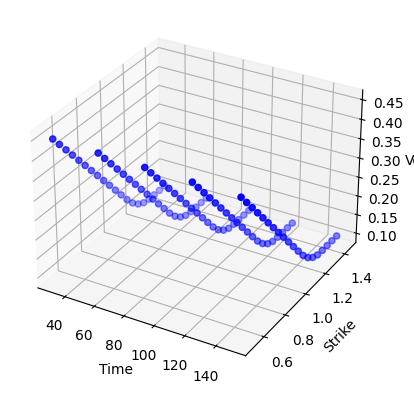

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(simulated_surface[:,0],simulated_surface[:,1] ,simulated_surface[:,2] , c='b')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

interpolation tps (pour test)

In [ ]:
min_vals = np.min(simulated_surface, axis=0) 
max_vals = np.max(simulated_surface, axis=0) 
normalized_data = (simulated_surface - min_vals) / (max_vals - min_vals)

scale = max_vals-min_vals
offset = min_vals

X,Y,Z = normalized_data[:,0],normalized_data[:,1],normalized_data[:,2]

In [ ]:
rbf = Rbf(X, Y, Z, function='thin_plate',smooth = 0.)

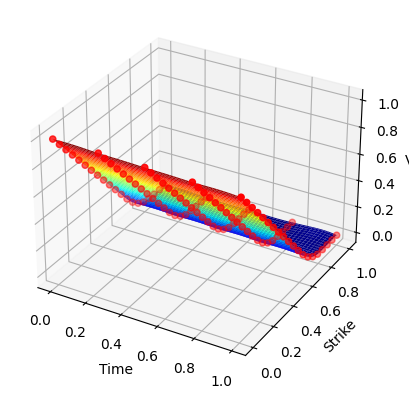

In [ ]:
x, y = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0.0, 1, 100))
z_interp = rbf(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z_interp, cmap='jet')
ax.scatter3D(X,Y,Z, c = 'r')
ax.set_xlabel('Time')
ax.set_ylabel('Strike')
ax.set_zlabel('Vol')
plt.show()

transformation en dict

In [ ]:
vol_dict = {}
for tenor in set(simulated_surface[:,0]):
    dict = {}
    indexes = np.where(simulated_surface==tenor)
    for index in indexes[0]:
        dict[simulated_surface[index,1]] = simulated_surface[index,2]
    vol_dict[tenor] = dict
print(vol_dict)

{150.0: {0.5: 0.4391611018363941, 0.55: 0.41411936560934887, 0.6: 0.38907762938230384, 0.65: 0.36403589315525875, 0.7: 0.3389941569282136, 0.75: 0.3139524207011686, 0.8: 0.2889106844741235, 0.85: 0.26386894824707835, 0.9: 0.23882721202003337, 0.95: 0.2137854757929884, 1.0: 0.1887437395659432, 1.05: 0.16370200333889812, 1.1: 0.139313765442404, 1.15: 0.12025804757929875, 1.2: 0.10746276377295494, 1.25: 0.10092791402337223, 1.3: 0.10000000000000005, 1.35: 0.10000000000000005, 1.4: 0.1, 1.45: 0.10000000000000005}, 120.0: {0.5: 0.4416652754590985, 0.55: 0.41662353923205353, 0.6: 0.39158180300500844, 0.65: 0.36654006677796325, 0.7: 0.34149833055091816, 0.75: 0.3164565943238731, 0.8: 0.291414858096828, 0.85: 0.26637312186978296, 0.9: 0.2413313856427379, 0.95: 0.21628964941569293, 1.0: 0.19124791318864773, 1.05: 0.16620617696160264, 1.1: 0.14156376794657763, 1.15: 0.12188200667779624, 1.2: 0.10846067946577627, 1.25: 0.1012997863105175, 1.3: 0.09999999999999999, 1.35: 0.09999999999999999, 1.4: 

## trop compliqué comme méthode

 Les points de la surface de vol locale sont interpolés une deuxième fois dans le pricer. Ca fait beaucoup de calculs. C'est inneficace. Mieux vaut directement implémenter la TPS + formule lien local vol/implied vol directement dans le pricer.

copie du fichier main.py dans la cellule d'en dessous

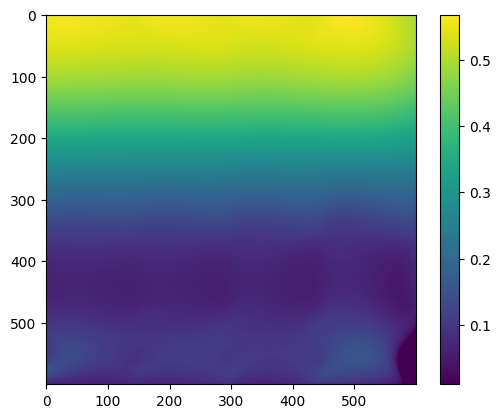

option volatility : 0.07545187643445711


/Users/leveilley/anaconda3/envs/deriv/lib/python3.9/site-packages/scipy/interpolate/_rgi.py:366: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xi = _ndim_coords_from_arrays(xi, ndim=ndim)


ValueError: setting an array element with a sequence.

In [ ]:
# Import timer class
import time

# Option parameters
S = 0.5
K = 0.51
r = 0.003
q = 0.01
T = 1
vol = vol_dict
American = False
smoothing = 0.00

# Select payoff
option_to_use = "call"
B = 120

# PDE parameters
N_x = 200
N_t = 400
scheme_to_use = "crank_nicolson_rannacher"
matrix_solver = "fast"
boundary = "dirichlet"  # Only supports Dirichlet currently
grid_shift = True


"""
Activate and run PDE pricer
"""

# Start timer
start = time.perf_counter_ns()

pricer = pde_pricer(
    ref_spot=S,
    strike=K,
    riskless_rates=r,
    dividend_rates=q,
    time_to_expiry=T,
    vols=vol,
    option=option_to_use,
    barrier=B,
    american=American,
    N_S=N_x,
    N_t=N_t,
    solver=matrix_solver,
    boundary=boundary,
    grid_shift=grid_shift,
    volsurface_type='strike',
    volsurface_interp='TPS_local_vol',
    smoothing=smoothing)  # Optional PDE arguments

# Get solutions
price_surface = pricer.get_price_surface(with_coords=True)
solution = pricer.get_price_curve(with_coords=True)

# Price specific point
spot = 0.5
tenor = 1
price = pricer.get_price(spot=spot, tenor=tenor)

stop = time.perf_counter_ns()

# i = S-axis, j = t-axis, k = V-axis
meshS = price_surface[:, :, 0]
mesht = price_surface[:, :, 1]
meshV = price_surface[:, :, 2]

# i = S-axis, j = V-axis
curveS = solution[:, 0]
curveV = solution[:, 1]

# Debugging prints
option_name = option_to_use.replace("_", " ").title()

print(f"\nOption payoff: {option_to_use}\nScheme: {scheme_to_use}\nMode: {matrix_solver}\n\n{N_x=}\n{N_t=}\nBoundary: {boundary}\n\nElapsed time: {(stop - start) * 1e-9} seconds")
print(f"{option_name} contract with {spot=}, {tenor=} has {price=}")


"""
Plots
"""
plt.close()

title_substring = f"{'American' if American else 'European'} {option_name} "

# Plot t-slices
for i in range(meshS.shape[1]):
    # if i % 10 == 0:
    plt.plot(meshS[:, i], meshV[:, i])
plt.title(title_substring + "Option Prices")
plt.xlabel("S")
plt.ylabel("V")
plt.draw()

# Plot lower spot boundary conditions
plt.figure()
plt.plot(mesht[0, :], meshV[0, :])
plt.title(title_substring + "Lower Spot Boundary Conditions")
plt.xlabel("t")
plt.ylabel("V")
plt.draw()

# Plot upper spot boundary conditions
plt.figure()
plt.plot(mesht[-1, :], meshV[-1, :])
plt.title(title_substring + "Upper Spot Boundary Conditions")
plt.xlabel("t")
plt.ylabel("V")
plt.draw()

# Plot t=0 solution
plt.figure()
plt.plot(meshS[:, 0], meshV[:, 0])
plt.title(title_substring + "Option Prices")
plt.xlabel("S")
plt.ylabel("V")
plt.draw()

# Plot T_max boundary conditions (payoff)
plt.figure()
plt.plot(meshS[:, -1], meshV[:, -1])
plt.title(title_substring + "Initial Conditions")
plt.xlabel("S")
plt.ylabel("V")
plt.draw()

# Plot 3d surface of option prices
fig = plt.figure()
ax = plt.axes(projection='3d', computed_zorder=False)

ax.plot_surface(meshS, mesht, meshV, rstride=1, cstride=1,
                cmap='plasma', edgecolor='none')
# We must cast tenor to T - tenor as the t-axis represents the starting
# time of the contract
ax.scatter(spot, T - tenor, price, c="#00ff00", alpha=1, depthshade=False)

ax.set_title(title_substring + "Option Prices")
ax.set_xlabel('S')
ax.set_ylabel('t')
ax.set_zlabel('V')
plt.draw()

plt.show()


ça commence un peu à marcher
reste qq problèmes : 
* La manière dont est fait le solveur  est la suivante. Quand il appelle $\sigma(t,s)$, il evalue la fonction $\sigma(t,.)$ (qui s'appelle smile dans le code) en le point $s$. A chaque pas de temps, il crée donc une fonction $\sigma(t,.)$ en appellant la classe VolSmileLocalVol. Or, en faisant ça, il refait tous les calculs d'interpolation de la volatilité implicite et de passage à la vol locale. --> Faut changer cela
* Le solveur n'autorise pas des valeurs de strike trop éloignées (à qq unités de volatilité) du spot courant (ou du spot initial d'ailleurs, je ne sais pas très bien, il faut que je regarde dans le détail). Le soucis est que le calcul de la vol locale à travers toutes les formules peut conduire à une vol locale nulle. Auquel cas le strike est contraint à être égal au spot. Cela est embêtant car on ne peut pricer que les options dont le strike est égal à la valeur du spot initial. 
* Pour l'instant, je fais le calcul de passage de la volatilité implicite à la volatilité locale dans des unités de monaie et de temps normalisées (de sorte à ce que les spots et maturités prennent leurs valeurs dans $[0,1]\times [0,1]$). Ensuite, je résoud la PDE de Black Scholes (généralisée) dans cette unité de monaie. Je fais ça car quand il y a une trop grande différence d'échelle entre le spot et la maturité, le calcul de volatilité locale ne se passe pas bien (il peut se passer que par endroits ou bien la dérivée seconde en temps est très grande --> vol locale nulle, ou bien denominateur très petit --> vol locale qui diverge vers $\infty$). Donc, j'obtiens les prix dans une unité de monaie normalisée. Il faut rescaler. A la rigueur, ce n'est pas très grave mais ce n'est pas très satisfaisant et surtout, pas cohérent avec le reste de l'application qui propose de pricer des options dans n'importe quelle unité de monaie. Bref, a regarder.
* Il existe toute une littérature sur la manière d'interpoler, et de lisser la volatilité. Pour l'instant, je le fais de manière "vanille". Il y a un monde de techniques à explorer pour rendre la surface de vol locale un peu plus "well behaved"

# TPS à la main (pas utile finalement)

In [ ]:
from scipy.spatial.distance import cdist

def kernel(x):
    return x*np.log(x)

class tps:

    def __init__(self,x,y,z,smooth) -> None:
        self.x =x 
        self.n = np.shape(x)[0]
        self.y = y
        self.z = z 
        self.smooth = smooth
        points = np.column_stack((self.x, self.y))
        dist_matrix = cdist(points, points, metric='sqeuclidean')**2
        for i in range(self.n):
            dist_matrix[i,i]=1
        self.matrix_A = kernel(dist_matrix)
        self.matrix_B = np.column_stack((np.ones(self.n),self.x,self.y))
        self.Lambda, self.d = self.compute_params()
        
    def compute_params(self):
        Q,R = np.linalg.qr(self.matrix_B,'complete')
        Q1,Q2 = Q[:,:3],Q[:,3:]
        R1= R[:3]
        product = np.dot(np.dot(Q2.T,self.matrix_A+self.smooth*np.identity(self.n)),Q2)
        inverse = np.linalg.inv(product)
        Lambda = np.dot(np.dot(np.dot(Q2,inverse),Q2.T),self.z.T)
        R1_inverse= np.linalg.inv(R1)
        d= np.dot(np.dot(R1_inverse,Q1.T),self.z.T-np.dot(self.matrix_A,Lambda))
        return Lambda,d
    
    def get_value_at(self,x,y):
        sum = 0
        for i in range(self.n):
            square_dist = (x-self.x[i])**2+(y-self.y[i])**2
            sum +=self.Lambda[i]*kernel(square_dist)
        sum += self.d[0]
        sum += self.d[1]*x
        sum += self.d[2]*y
        return sum
    
    def partial_x(self,x,y):
        sum = 0
        for i in range(self.n):
            square_dist = (x-self.x[i])**2+(y-self.y[i])**2
            sum += self.Lambda[i]*2*x*(x-self.x[i])*(np.log(square_dist)+1)
        sum +=self.d[1]
        return sum

    def partial_y(self,x,y):
        sum = 0
        for i in range(self.n):
            square_dist = (x-self.x[i])**2+(y-self.y[i])**2
            sum += self.Lambda[i]*2*y*(y-self.y[i])*(np.log(square_dist)+1)
        sum +=self.d[2]
        return sum

    def partial_y_2(self,x,y):
        sum = 0
        for i in range(self.n):
            square_dist = (x-self.x[i])**2+(y-self.y[i])**2
            sum += self.Lambda[i]*2*((2*y-self.y[i])*(np.log(square_dist)+1)+2*y*y*(y-self.y[i])*(y-self.y[i])/square_dist)
        return sum

In [ ]:
TPS = tps(X,Y,Z,0.1)

In [ ]:
tab= np.zeros((100,100))
for i in range(100):
        x_i = i/100
        for j in range(100):
            y_j= j/100
            tab[i,j]= TPS.get_value_at(x_i,y_j)


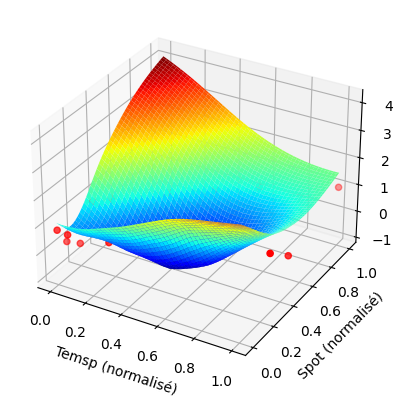

In [ ]:
absc, ord =np.meshgrid(np.linspace(0,1,100),np.linspace(0,1,100))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(absc, ord, tab.T, cmap='jet')
ax.scatter3D(X,Y,Z, c = 'r')
ax.set_xlabel('Temsp (normalisé)')
ax.set_ylabel('Spot (normalisé)')
ax.set_zlabel('Vol')
plt.show()

# Test de la classe volsurface

In [ ]:
from pricer.market.volsurface.volsurface import VolSurface

In [ ]:
smile_kwargs = {'S' :spot_initial,'r' : 0.01, 'smoothing':0.0}
volsurface_TPS_loc_vol = VolSurface(vol_dict,'strike','TPS_local_vol',**smile_kwargs)

In [ ]:
volsurface_TPS_loc_vol.get_volatility(0.6,0.5)

array([0.01])

In [ ]:
from scipy.interpolate import Rbf,interp2d,RegularGridInterpolator

array = np.ones((10,10))
absc, oord = np.linspace(0,1,10),np.linspace(0,1,10)
func = RegularGridInterpolator((absc,oord),array)
np.shape(func([0.1,0.2]))

(1,)